In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import numpy as np
import scipy.io as sio
import os
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.utils import shuffle
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Dense, Flatten, Dropout, 
                                     Conv3D, MaxPooling3D, BatchNormalization, LSTM, Reshape)

# Load the saved dataset
dataset = np.load("/kaggle/input/de-lds-mat-seed-dataset-de-features/SEED_SCS_LDS_label.npy", allow_pickle=True).item()

# Extract data and labels
datas = dataset["data"]
labelss = dataset["labels"]
# Common SEED channels corresponding to DEAP
# Common SEED channels corresponding to DEAP
seed_indices = [3, 4, 7, 11, 5, 13, 15, 21, 58, 60, 41, 49, 23, 31]

# Adjust index from 1-based (human-readable) to 0-based (Python)
deap_channel_indices = [ch - 1 for ch in seed_indices]

# Select only the 32 DEAP-matching channels
datas = datas[:, deap_channel_indices, :, :]

# Print shapes
print("Data shape:", datas.shape)  # Expected: (675, 62, windows, 5)
print("Labels shape:", labelss.shape)  # Expected: (675,)


# Shuffle data and labels together
datas, labelss = shuffle(datas, labelss, random_state=42)

# Verify shuffled shapes
print("Shuffled Data shape:", datas.shape)  # Should be (675, 62, 265, 5)
print("Shuffled Labels shape:", labelss.shape)  # Should be (675,)


Data shape: (675, 14, 185, 5)
Labels shape: (675,)
Shuffled Data shape: (675, 14, 185, 5)
Shuffled Labels shape: (675,)


In [2]:
import numpy as np
from tensorflow.keras.utils import to_categorical

# Initialize the list for storing results
cumul = []
for i in range(4):
    cumul.append([])

# Normalize data
max_val = np.max(datas)
min_val = np.min(datas)

# You can apply either of the normalization methods, not both
# Option 1: Min-Max normalization
datas = (datas - min_val) / (max_val - min_val)

# Option 2: Z-score normalization (if you prefer this instead)
# data = (data - np.mean(data)) / np.std(data)

# Crop the end time segments
datas = datas[:,:,0:250,:]

# Split Dataset into train, validation, test
train_labels = labelss[0:550]
test_labels = labelss[550:600]
train_data = datas[0:550]
test_data = datas[550:600]
final_test = datas[600:675]
final_labels = labelss[600:675]

# Handle the final labels (e.g., replacing -1 with 2 for confusion matrix)
cf_labels = np.where(final_labels == -1, 2, final_labels)
un, co = np.unique(cf_labels, return_counts=True)
print(f'Unique: {un}, Counts: {co}')

# Reshape labels for CNN input
train_labels_reshaped = train_labels.reshape(-1, 1)
test_labels_reshaped = test_labels.reshape(-1, 1)
final_labels_reshaped = final_labels.reshape(-1, 1)

# One-hot encode labels
train_labels_reshaped = to_categorical(train_labels_reshaped, 3)
test_labels_reshaped = to_categorical(test_labels_reshaped, 3)
final_labels_reshaped = to_categorical(final_labels_reshaped, 3)

# Prepare data for RNN (reshape and transpose for proper input shape)
rnn_train = train_data.reshape(550, 14, -1)
rnn_test = test_data.reshape(50, 14, -1)

# Transpose to fit the RNN input shape (samples, timesteps, features)
rnn_train = np.transpose(rnn_train, (0, 2, 1))  # (550, 250, 62)
rnn_test = np.transpose(rnn_test, (0, 2, 1))    # (50, 250, 62)

# Print shapes for verification
print("Train data shape:", train_data.shape)
print("RNN train data shape:", rnn_train.shape)

Unique: [0 1 2], Counts: [25 22 28]
Train data shape: (550, 14, 185, 5)
RNN train data shape: (550, 925, 14)


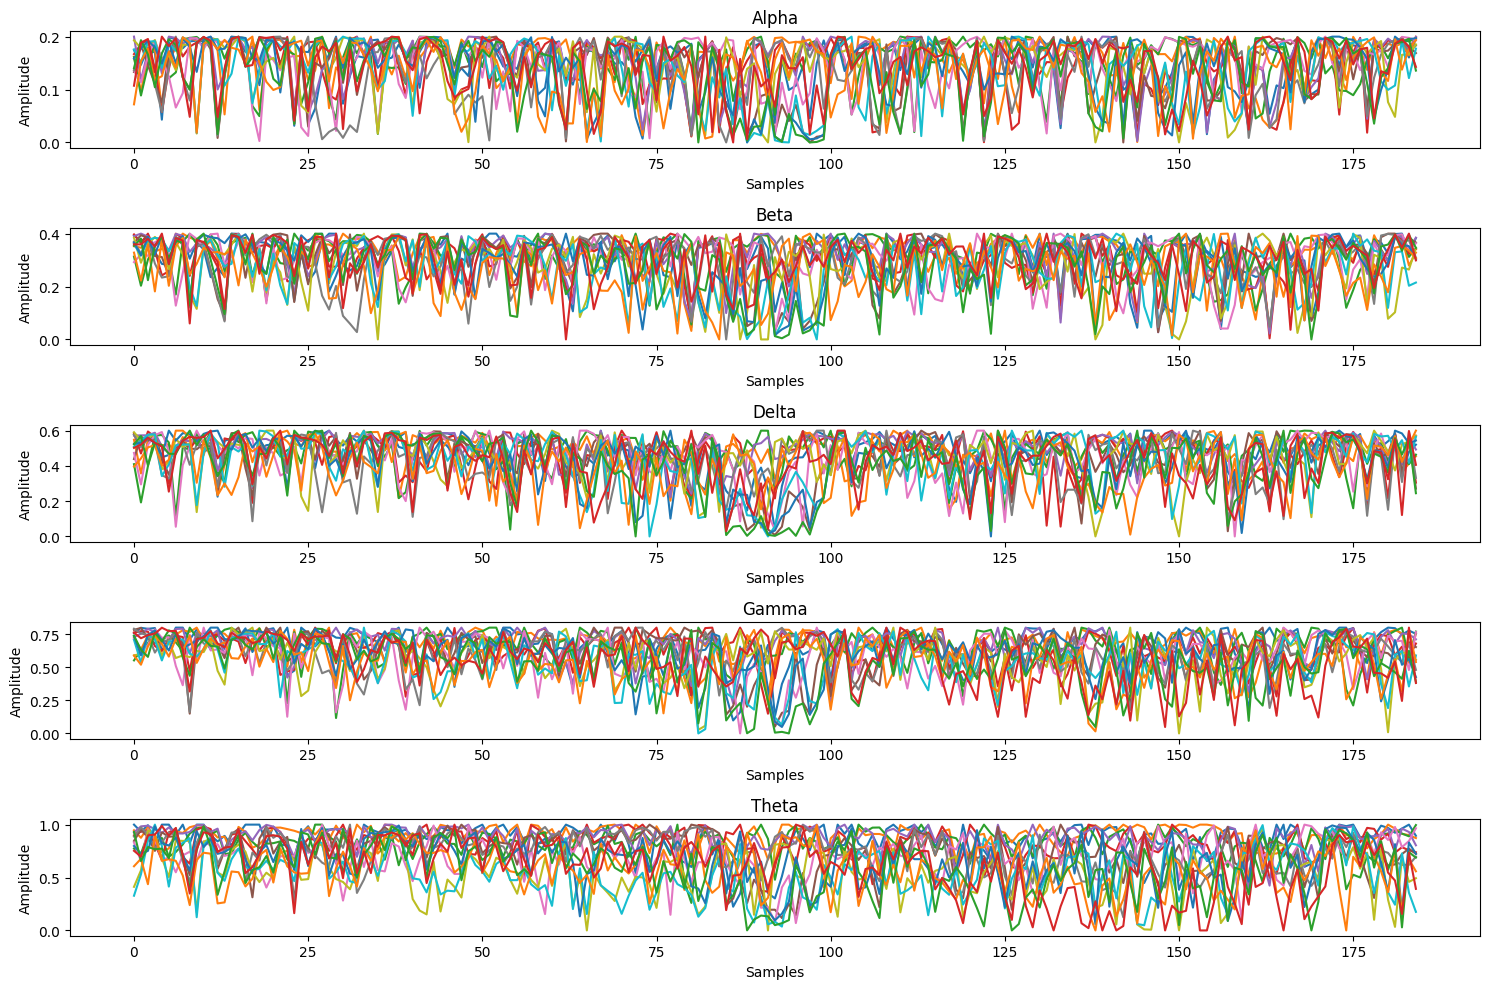

In [3]:
import matplotlib.pyplot as plt

# Create subplots for the 5 frequency bands
fig, a = plt.subplots(5, 1, squeeze=False, figsize=(15, 10))
titles = ['Alpha', 'Beta', 'Delta', 'Gamma', 'Theta']

# Loop over the frequency bands
for cnt in range(5):
    # Loop over the samples in test_data for the given segment
    for i in range(len(train_data[5])):  # assuming index 5 is correct for your test_data
        # Plot the signal for the i-th sample and the cnt-th frequency band
        a[cnt][0].plot(range(train_data[5].shape[1]), train_data[5][i, :, cnt])  # Shape of test_data[5] is (samples, 250, 5)
    
    # Set titles and labels for each subplot
    a[cnt][0].set_title(titles[cnt])
    a[cnt][0].set_xlabel('Samples')
    a[cnt][0].set_ylabel('Amplitude')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


🔍 Testing Kernel Size: 7x7

 Fold 1/10...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.3896 - loss: 1.1369 - val_accuracy: 0.2727 - val_loss: 1.3228 - learning_rate: 9.0000e-05
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 207ms/step - accuracy: 0.3720 - loss: 1.1406 - val_accuracy: 0.4909 - val_loss: 1.0558 - learning_rate: 9.0000e-05
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 206ms/step - accuracy: 0.4846 - loss: 1.0238 - val_accuracy: 0.4909 - val_loss: 1.0276 - learning_rate: 9.0000e-05
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 206ms/step - accuracy: 0.5587 - loss: 0.9196 - val_accuracy: 0.6182 - val_loss: 0.9066 - learning_rate: 9.0000e-05
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 206ms/step - accuracy: 0.6477 - loss: 0.8061 - val_accuracy: 0.7455 - val_loss: 0.7248 - learning_rate: 9.0000e-05
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 206ms/step - accuracy: 0.6629 - loss: 0.7631 - val_accuracy: 0.6364 - val_loss: 0.7599 - learning_rate: 9.0000e-05
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 206ms/step - accuracy: 0.7096 - loss: 0

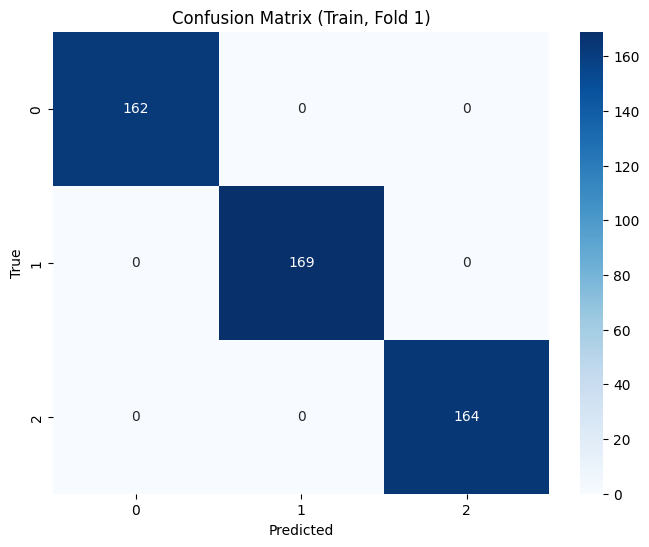

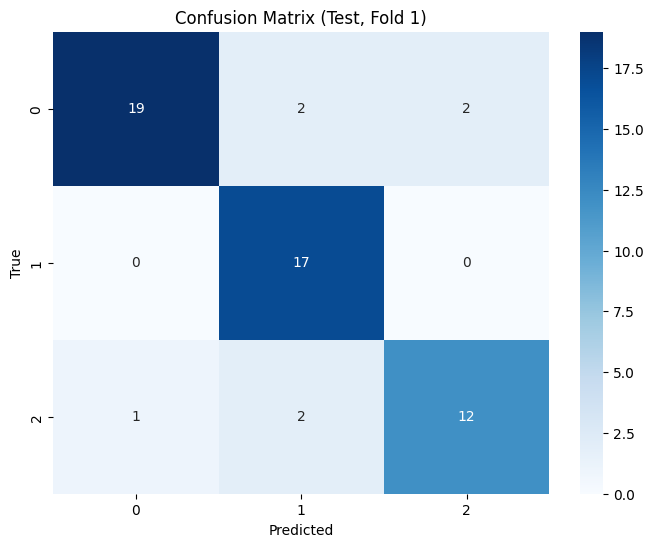


 Fold 2/10...
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 936ms/step - accuracy: 0.3376 - loss: 1.1323 - val_accuracy: 0.2364 - val_loss: 1.0893 - learning_rate: 9.0000e-05
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 206ms/step - accuracy: 0.4096 - loss: 1.1130 - val_accuracy: 0.4000 - val_loss: 1.0228 - learning_rate: 9.0000e-05
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 206ms/step - accuracy: 0.5157 - loss: 0.9799 - val_accuracy: 0.6182 - val_loss: 0.8749 - learning_rate: 9.0000e-05
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 206ms/step - accuracy: 0.5562 - loss: 0.9197 - val_accuracy: 0.7091 - val_loss: 0.8210 - learning_rate: 9.0000e-05
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 206ms/step - accuracy: 0.5919 - loss: 0.8531 - val_accuracy: 0.7455 - val_loss: 0.7503 - learning_rate: 9.0000e-05
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 206ms/step - accuracy: 0.6491 - loss: 0.7656 - val_accuracy: 0.7455 - val_loss: 0.7078 - learning_rate: 9.0000e-05
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 206ms/step - accuracy: 0.6303 - loss: 0.7823 - 

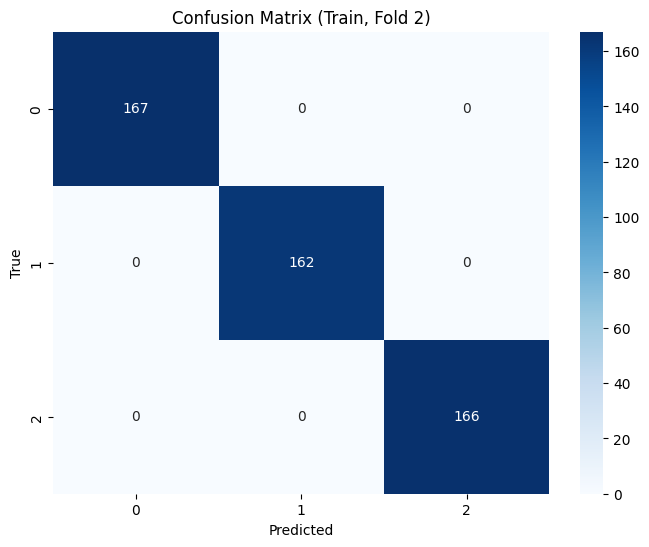

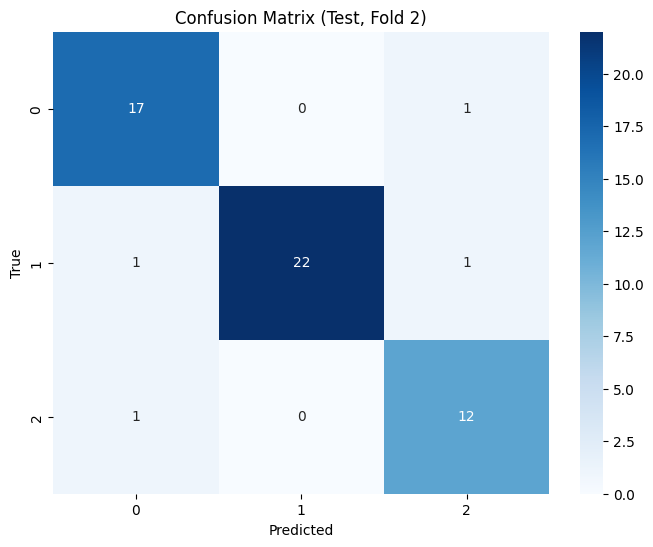


 Fold 3/10...
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 939ms/step - accuracy: 0.3229 - loss: 1.1388 - val_accuracy: 0.3455 - val_loss: 1.0971 - learning_rate: 9.0000e-05
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 206ms/step - accuracy: 0.3511 - loss: 1.1335 - val_accuracy: 0.3091 - val_loss: 1.0725 - learning_rate: 9.0000e-05
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 206ms/step - accuracy: 0.4382 - loss: 1.0336 - val_accuracy: 0.6182 - val_loss: 0.8452 - learning_rate: 9.0000e-05
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 206ms/step - accuracy: 0.5537 - loss: 0.9298 - val_accuracy: 0.6727 - val_loss: 0.8291 - learning_rate: 9.0000e-05
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 206ms/step - accuracy: 0.5756 - loss: 0.8877 - val_accuracy: 0.7091 - val_loss: 0.7501 - learning_rate: 9.0000e-05
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 206ms/step - accuracy: 0.6429 - loss: 0.7881 - val_accuracy: 0.5455 - val_loss: 0.7464 - learning_rate: 9.0000e-05
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 206ms/step - accuracy: 0.6715 - loss: 0.7969 - 

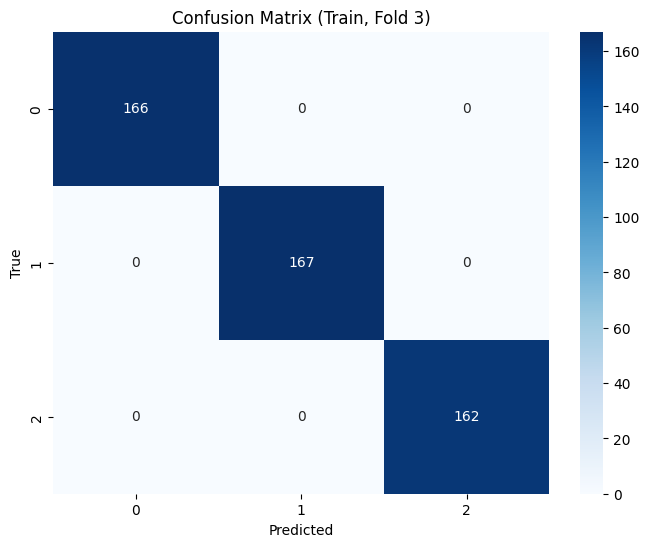

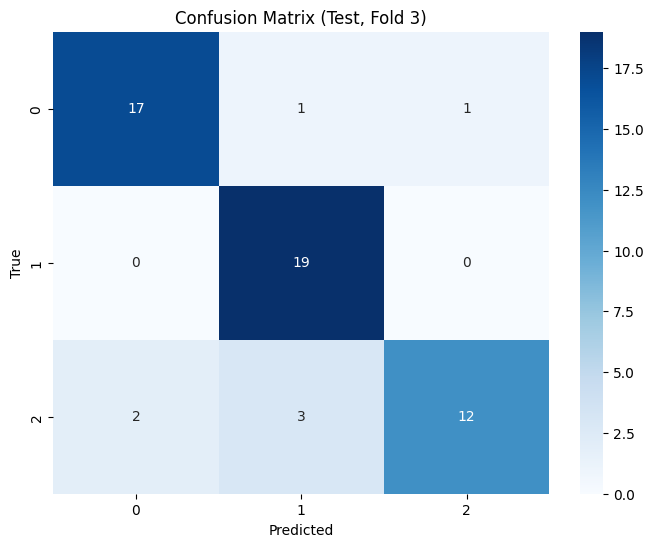


 Fold 4/10...
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 777ms/step - accuracy: 0.3114 - loss: 1.1447 - val_accuracy: 0.4182 - val_loss: 1.0791 - learning_rate: 9.0000e-05
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 206ms/step - accuracy: 0.3565 - loss: 1.1514 - val_accuracy: 0.3455 - val_loss: 1.1664 - learning_rate: 9.0000e-05
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 206ms/step - accuracy: 0.4087 - loss: 1.0994 - val_accuracy: 0.4727 - val_loss: 1.0528 - learning_rate: 9.0000e-05
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 206ms/step - accuracy: 0.5834 - loss: 0.9216 - val_accuracy: 0.5818 - val_loss: 0.8938 - learning_rate: 9.0000e-05
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 206ms/step - accuracy: 0.6301 - loss: 0.8346 - val_accuracy: 0.5818 - val_loss: 1.0079 - learning_rate: 9.0000e-05
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 206ms/step - accuracy: 0.6558 - loss: 0.7453 - val_accuracy: 0.5455 - val_loss: 0.8956 - learning_rate: 9.0000e-05
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 206ms/step - accuracy: 0.6500 - loss: 0.7584 - 

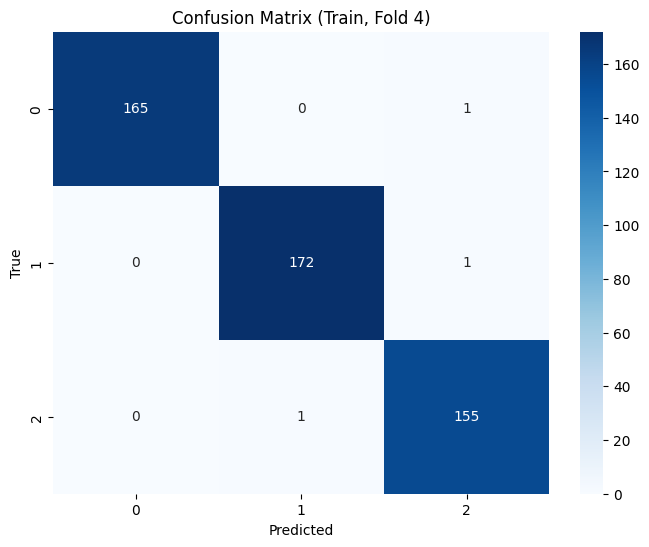

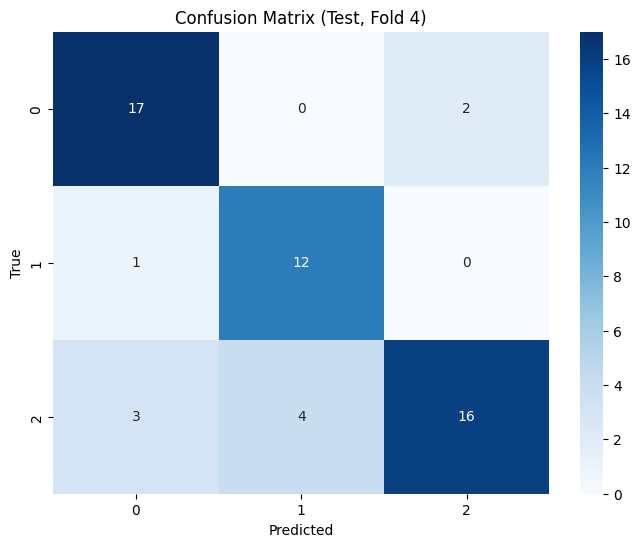


 Fold 5/10...
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 804ms/step - accuracy: 0.3282 - loss: 1.1364 - val_accuracy: 0.3091 - val_loss: 1.1044 - learning_rate: 9.0000e-05
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 206ms/step - accuracy: 0.3681 - loss: 1.1215 - val_accuracy: 0.3091 - val_loss: 1.0883 - learning_rate: 9.0000e-05
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 206ms/step - accuracy: 0.3887 - loss: 1.0804 - val_accuracy: 0.5818 - val_loss: 0.9408 - learning_rate: 9.0000e-05
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 206ms/step - accuracy: 0.5637 - loss: 0.9316 - val_accuracy: 0.5455 - val_loss: 0.9030 - learning_rate: 9.0000e-05
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 206ms/step - accuracy: 0.5773 - loss: 0.8972 - val_accuracy: 0.6364 - val_loss: 0.7911 - learning_rate: 9.0000e-05
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 206ms/step - accuracy: 0.6208 - loss: 0.8486 - val_accuracy: 0.5818 - val_loss: 0.7845 - learning_rate: 9.0000e-05
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 206ms/step - accuracy: 0.6996 - loss: 0.7396 - 

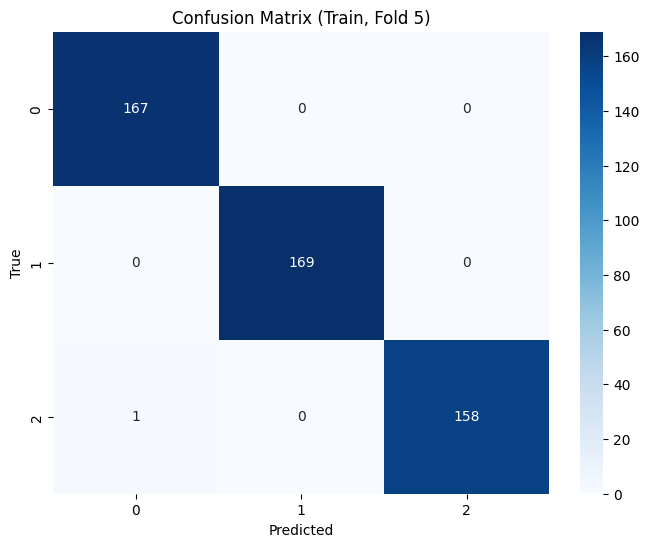

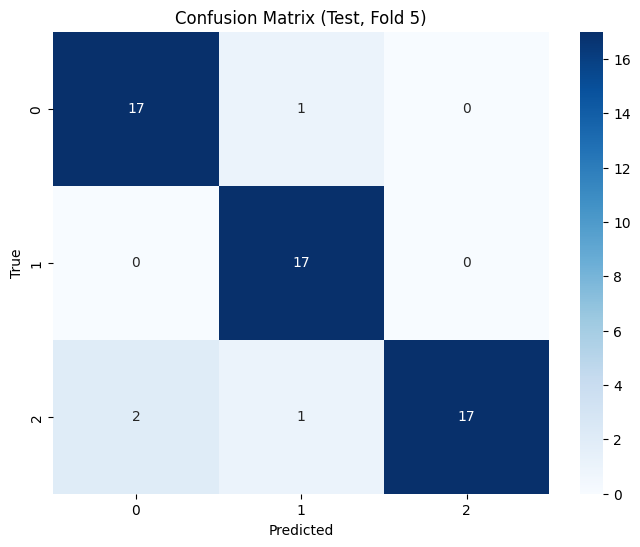


 Fold 6/10...
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 788ms/step - accuracy: 0.3173 - loss: 1.1653 - val_accuracy: 0.3818 - val_loss: 1.1332 - learning_rate: 9.0000e-05
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 206ms/step - accuracy: 0.3740 - loss: 1.1166 - val_accuracy: 0.4909 - val_loss: 1.1385 - learning_rate: 9.0000e-05
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 206ms/step - accuracy: 0.3965 - loss: 1.0950 - val_accuracy: 0.5455 - val_loss: 0.9720 - learning_rate: 9.0000e-05
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 206ms/step - accuracy: 0.5309 - loss: 0.9711 - val_accuracy: 0.5636 - val_loss: 0.8264 - learning_rate: 9.0000e-05
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 206ms/step - accuracy: 0.5778 - loss: 0.8886 - val_accuracy: 0.5636 - val_loss: 0.8174 - learning_rate: 9.0000e-05
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 207ms/step - accuracy: 0.6421 - loss: 0.8086 - val_accuracy: 0.7636 - val_loss: 0.5992 - learning_rate: 9.0000e-05
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 206ms/step - accuracy: 0.6712 - loss: 0.7579 - 

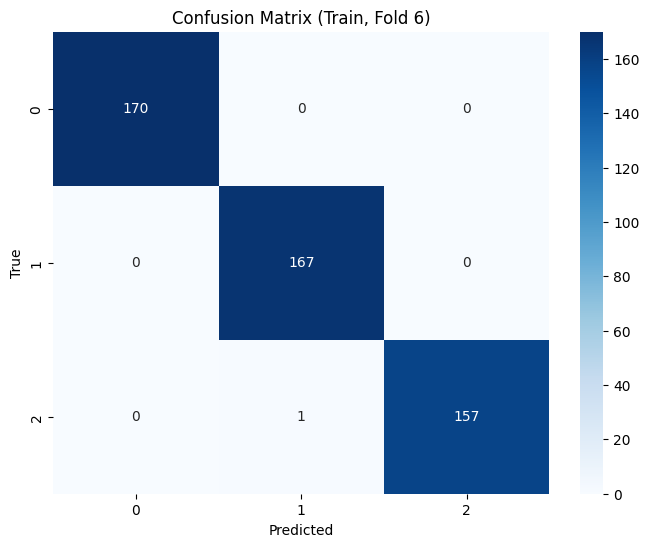

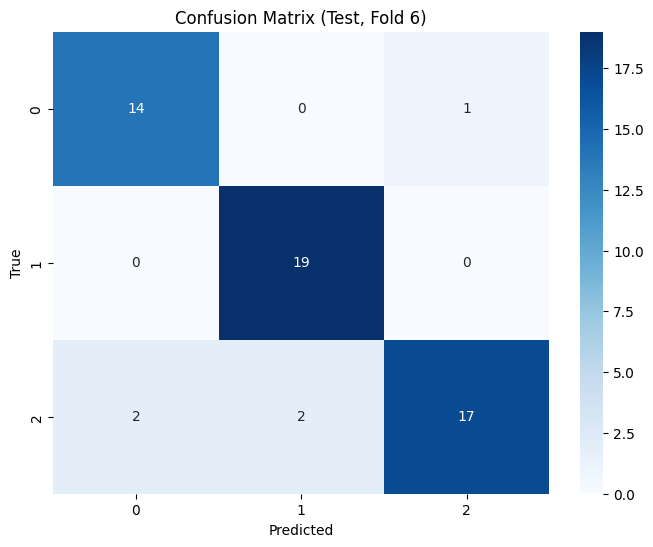


 Fold 7/10...
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 792ms/step - accuracy: 0.3617 - loss: 1.1733 - val_accuracy: 0.3273 - val_loss: 1.0768 - learning_rate: 9.0000e-05
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 206ms/step - accuracy: 0.3897 - loss: 1.0940 - val_accuracy: 0.6000 - val_loss: 0.9719 - learning_rate: 9.0000e-05
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 205ms/step - accuracy: 0.5371 - loss: 0.9623 - val_accuracy: 0.5273 - val_loss: 0.8818 - learning_rate: 9.0000e-05
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 206ms/step - accuracy: 0.5707 - loss: 0.8552 - val_accuracy: 0.6364 - val_loss: 0.8434 - learning_rate: 9.0000e-05
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 206ms/step - accuracy: 0.6345 - loss: 0.8107 - val_accuracy: 0.7091 - val_loss: 0.7889 - learning_rate: 9.0000e-05
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 206ms/step - accuracy: 0.6612 - loss: 0.7997 - val_accuracy: 0.6727 - val_loss: 0.7484 - learning_rate: 9.0000e-05
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 205ms/step - accuracy: 0.6961 - loss: 0.7236 - 

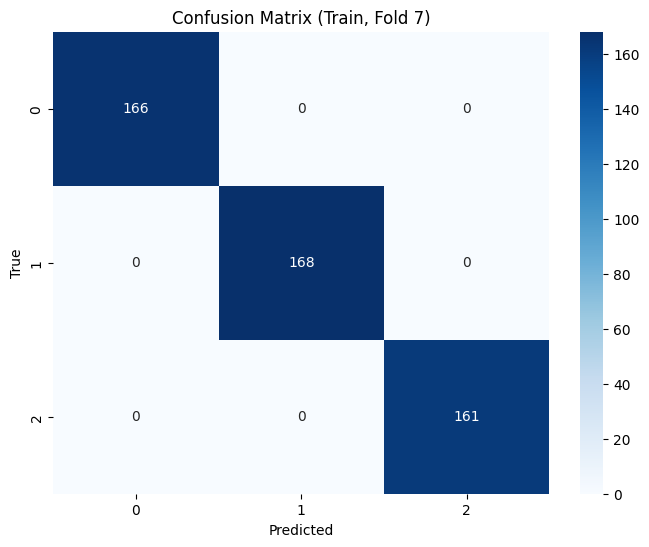

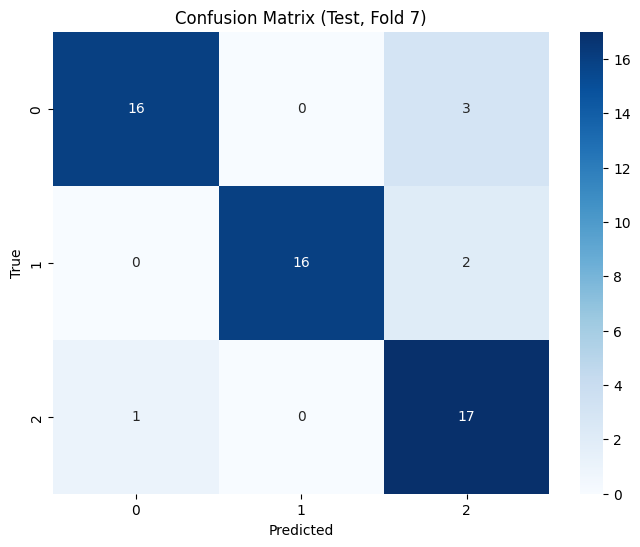


 Fold 8/10...
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 800ms/step - accuracy: 0.3363 - loss: 1.1468 - val_accuracy: 0.3091 - val_loss: 1.0935 - learning_rate: 9.0000e-05
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 206ms/step - accuracy: 0.3746 - loss: 1.1016 - val_accuracy: 0.5091 - val_loss: 1.0664 - learning_rate: 9.0000e-05
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 206ms/step - accuracy: 0.4168 - loss: 1.0586 - val_accuracy: 0.5455 - val_loss: 0.8993 - learning_rate: 9.0000e-05
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 206ms/step - accuracy: 0.5660 - loss: 0.9165 - val_accuracy: 0.5818 - val_loss: 0.7668 - learning_rate: 9.0000e-05
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 206ms/step - accuracy: 0.6443 - loss: 0.7713 - val_accuracy: 0.7091 - val_loss: 0.6747 - learning_rate: 9.0000e-05
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 206ms/step - accuracy: 0.7095 - loss: 0.7091 - val_accuracy: 0.7091 - val_loss: 0.7055 - learning_rate: 9.0000e-05
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 206ms/step - accuracy: 0.7066 - loss: 0.6988 - 

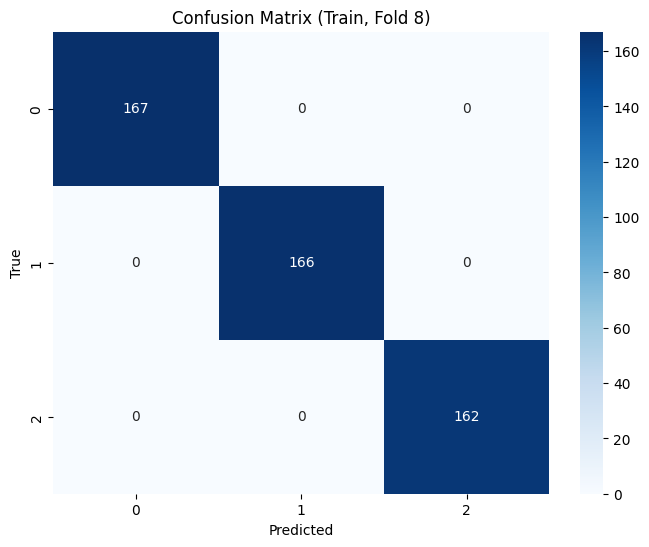

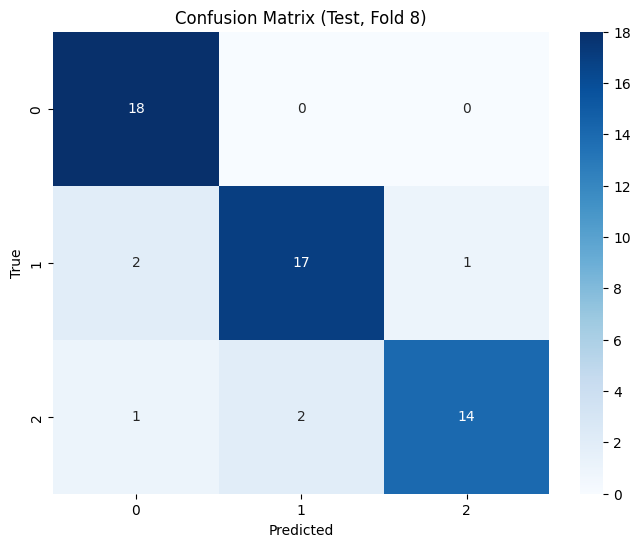


 Fold 9/10...
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 795ms/step - accuracy: 0.3123 - loss: 1.1268 - val_accuracy: 0.6545 - val_loss: 1.0468 - learning_rate: 9.0000e-05
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 206ms/step - accuracy: 0.3958 - loss: 1.0941 - val_accuracy: 0.6000 - val_loss: 0.8945 - learning_rate: 9.0000e-05
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 206ms/step - accuracy: 0.5728 - loss: 0.8973 - val_accuracy: 0.6364 - val_loss: 0.8409 - learning_rate: 9.0000e-05
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 206ms/step - accuracy: 0.6640 - loss: 0.8462 - val_accuracy: 0.6909 - val_loss: 0.6992 - learning_rate: 9.0000e-05
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 207ms/step - accuracy: 0.6786 - loss: 0.7507 - val_accuracy: 0.6545 - val_loss: 0.7406 - learning_rate: 9.0000e-05
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 206ms/step - accuracy: 0.6598 - loss: 0.7628 - val_accuracy: 0.7273 - val_loss: 0.6435 - learning_rate: 9.0000e-05
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 206ms/step - accuracy: 0.7221 - loss: 0.6834 - 

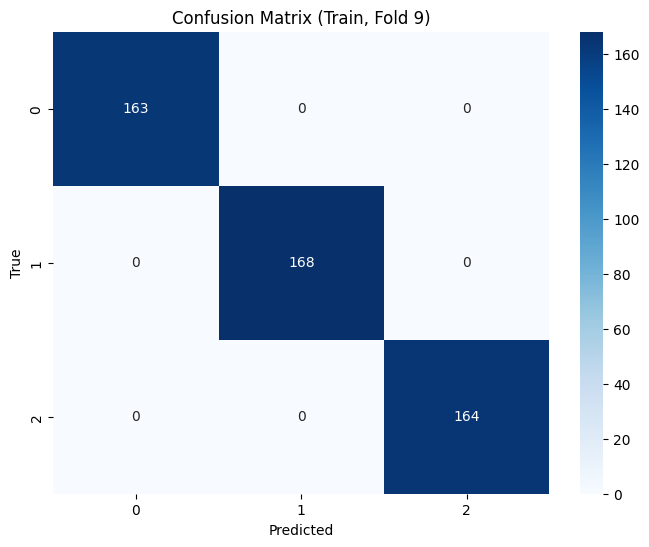

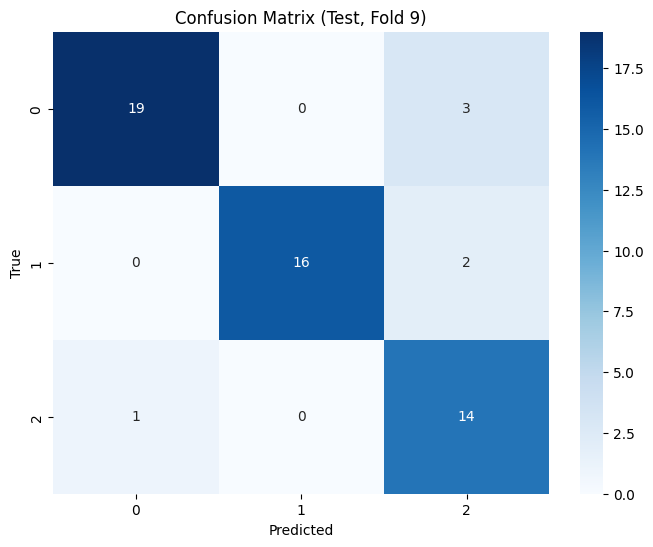


 Fold 10/10...
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 783ms/step - accuracy: 0.3041 - loss: 1.1489 - val_accuracy: 0.2545 - val_loss: 1.1630 - learning_rate: 9.0000e-05
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 207ms/step - accuracy: 0.3810 - loss: 1.1046 - val_accuracy: 0.4545 - val_loss: 1.0995 - learning_rate: 9.0000e-05
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 206ms/step - accuracy: 0.4357 - loss: 1.0672 - val_accuracy: 0.5091 - val_loss: 0.9759 - learning_rate: 9.0000e-05
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 206ms/step - accuracy: 0.5486 - loss: 0.9347 - val_accuracy: 0.4545 - val_loss: 0.9305 - learning_rate: 9.0000e-05
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 206ms/step - accuracy: 0.6031 - loss: 0.8803 - val_accuracy: 0.6000 - val_loss: 0.8559 - learning_rate: 9.0000e-05
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 206ms/step - accuracy: 0.6488 - loss: 0.7995 - val_accuracy: 0.5091 - val_loss: 0.8842 - learning_rate: 9.0000e-05
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 206ms/step - accuracy: 0.6566 - loss: 0.7622 - 

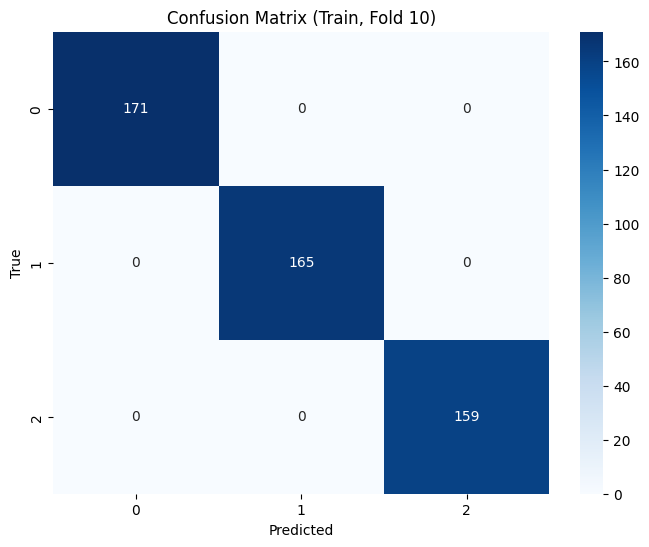

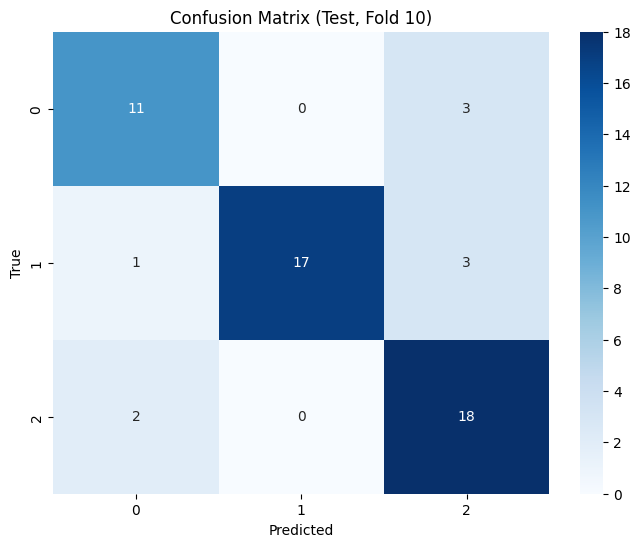


✅ All results saved successfully!


In [4]:
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow import keras
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.utils import shuffle

# Hyperparameters
BATCH_SIZE = 64
EPOCHS = 50  
KERNEL_SIZES = [7]  

# Duplicate Data 10x (If Needed)
X_duplicated = np.tile(train_data, (1, 1, 1, 1))
y_duplicated = np.tile(train_labels_reshaped, (1, 1))
X_duplicated, y_duplicated = shuffle(X_duplicated, y_duplicated, random_state=42)

# K-Fold Settings
num_folds = 10
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Store Results
fold_results = []

# Loop through different kernel sizes
for kernel_size in KERNEL_SIZES:
    print(f"\n🔍 Testing Kernel Size: {kernel_size}x{kernel_size}")

    for fold, (train_idx, val_idx) in enumerate(kf.split(X_duplicated)):
        print(f"\n Fold {fold+1}/{num_folds}...")

        # Split data
        X_train, X_val = X_duplicated[train_idx], X_duplicated[val_idx]
        y_train, y_val = y_duplicated[train_idx], y_duplicated[val_idx]

        # Define model
        model = Sequential([
            Conv2D(filters=64, kernel_size=kernel_size, input_shape=(14, 185, 5), padding='same'),
            Conv2D(filters=64, kernel_size=kernel_size, padding='same'),
            Conv2D(filters=64, kernel_size=kernel_size, padding='same'),
            MaxPooling2D(pool_size=(1, 2), strides=(1, 2)),
            Dropout(rate=0.3),

            Conv2D(filters=128, kernel_size=kernel_size, padding='same'),
            Conv2D(filters=128, kernel_size=kernel_size, padding='same'),
            MaxPooling2D(pool_size=(1, 2), strides=(1, 2)),
            Dropout(rate=0.2),

            Conv2D(filters=256, kernel_size=kernel_size, padding='same'),
            MaxPooling2D(pool_size=(1, 2), strides=(1, 2)),
            Dropout(rate=0.25),

            Conv2D(filters=512, kernel_size=kernel_size, padding='same'),
            MaxPooling2D(pool_size=(1, 2), strides=(1, 2)),
            Dropout(rate=0.3),

            Flatten(),

            Dense(512, activation='relu'),
            Dropout(rate=0.4),
            Dense(256, activation='relu'),
            Dropout(rate=0.2),
            Dense(64, activation='relu'),
            Dense(3, activation='softmax')  # Output layer for 3 classes
        ])


        # Compile model
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=9e-5),
            loss=keras.losses.categorical_crossentropy,
            metrics=['accuracy']
        )

        # Define learning rate annealer
        reduce_lr_cnn = ReduceLROnPlateau(
            monitor='val_loss', factor=0.3, patience=5, min_lr=1e-7
        )

        # Train model
        history = model.fit(
            X_train, y_train,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            validation_data=(X_val, y_val),
            callbacks=[reduce_lr_cnn],
            verbose=1
        )

        # Evaluate model
        train_acc = history.history['accuracy'][-1]
        val_acc = history.history['val_accuracy'][-1]
        train_loss = history.history['loss'][-1]
        val_loss = history.history['val_loss'][-1]

        fold_results.append({
            "fold": fold + 1,
            "train_loss": train_loss,
            "val_loss": val_loss,
            "train_acc": train_acc,
            "val_acc": val_acc
        })

        # Predictions
        y_train_pred = np.argmax(model.predict(X_train), axis=1)
        y_train_true = np.argmax(y_train, axis=1)
        y_test_pred = np.argmax(model.predict(X_val), axis=1)
        y_test_true = np.argmax(y_val, axis=1)

        # Confusion Matrix & Classification Report for Train & Test
        for dataset, y_true, y_pred, label in [
            (X_train, y_train_true, y_train_pred, "Train"),
            (X_val, y_test_true, y_test_pred, "Test")
        ]:
            # Confusion Matrix
            conf_matrix = confusion_matrix(y_true, y_pred)
            plt.figure(figsize=(8, 6))
            sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
            plt.xlabel("Predicted")
            plt.ylabel("True")
            plt.title(f"Confusion Matrix ({label}, Fold {fold+1})")
            plt.show()

            # Save Confusion Matrix
            conf_matrix_df = pd.DataFrame(conf_matrix)
            conf_matrix_df.to_csv(f"conf_matrix_{label.lower()}_fold_{fold+1}.csv")

            # Classification Report (Text Format)
            class_report = classification_report(y_true, y_pred, output_dict=False)
            with open(f"class_report_{label.lower()}_fold_{fold+1}.txt", "w") as f:
                f.write(class_report)

# Save all fold results in CSV
results_df = pd.DataFrame(fold_results)
results_df.to_csv("train_test_acc_loss_all_folds.csv", index=False)

print("\n✅ All results saved successfully!")
model.save("SEED Paper 14 channel Kernel 7.h5")